In [ ]:
# Paths
uploaded_file_path = '/content/JutePest_dataset.zip'
extracted_path = '/content/JutePest_dataset'
split_dir = os.path.join(extracted_path, 'split_dataset')
train_dir = os.path.join(split_dir, 'train')
val_dir = os.path.join(split_dir, 'val')
test_dir = os.path.join(split_dir, 'test')

In [ ]:
# Step 1: Unzip the uploaded dataset
import zipfile
with zipfile.ZipFile(uploaded_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

print(f"Dataset unzipped successfully to: {extracted_path}")

# Step 2: Ensure the split directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

Dataset unzipped successfully to: /content/JutePest_dataset


In [ ]:
# Prepare data for splitting
dataset_dir = os.path.join(extracted_path, 'JutePest_dataset')
all_images = []
all_labels = []

for label in sorted(os.listdir(dataset_dir)):
    class_dir = os.path.join(dataset_dir, label)
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            all_images.append(img_path)
            all_labels.append(label)

In [ ]:
# Split dataset: 70% train, 20% val, 10% test
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(
    all_images, all_labels, test_size=0.3, stratify=all_labels, random_state=42
)
val_imgs, test_imgs, val_labels, test_labels = train_test_split(
    temp_imgs, temp_labels, test_size=1/3, stratify=temp_labels, random_state=42
)

In [ ]:
# Create directories for the split datasets
def copy_images(image_paths, labels, target_dir):
    for img_path, label in zip(image_paths, labels):
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, os.path.join(label_dir, os.path.basename(img_path)))

# Copy images to split directories
copy_images(train_imgs, train_labels, train_dir)
copy_images(val_imgs, val_labels, val_dir)
copy_images(test_imgs, test_labels, test_dir)
print("Dataset successfully split into training, validation, and testing sets.")

Dataset successfully split into training, validation, and testing sets.


In [ ]:
# Print the total number of images in each split
print(f"Total images in training set: {len(train_imgs)}")
print(f"Total images in validation set: {len(val_imgs)}")
print(f"Total images in testing set: {len(test_imgs)}")

Total images in training set: 5009
Total images in validation set: 1431
Total images in testing set: 716


In [ ]:
# Model Parameters
img_height, img_width = 299, 299  # Xception model requires 299x299 images
batch_size = 32
num_epochs = 25

In [ ]:
# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)

In [ ]:
# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 5008 images belonging to 17 classes.
Found 1431 images belonging to 17 classes.
Found 716 images belonging to 17 classes.


In [ ]:
# Load the Xception model with pre-trained weights
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Fine-tuning the model (you can choose to freeze layers as needed)
for layer in base_model.layers:
    layer.trainable = True

# Adding custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
model_checkpoint = ModelCheckpoint('xception_best_model.keras', save_best_only=True, monitor='val_loss')

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=val_generator,
    callbacks=model_checkpoint
)


Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


157/157 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - accuracy: 0.6123 - loss: 1.5439 - val_accuracy: 0.9574 - val_loss: 0.1580
Epoch 2/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.9763 - loss: 0.0981 - val_accuracy: 0.9804 - val_loss: 0.0671
Epoch 3/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 197s 997ms/step - accuracy: 0.9924 - loss: 0.0365 - val_accuracy: 0.9797 - val_loss: 0.0683
Epoch 4/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.9913 - loss: 0.0340 - val_accuracy: 0.9846 - val_loss: 0.0685
Epoch 5/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9926 - loss: 0.0238 - val_accuracy: 0.9867 - val_loss: 0.0549
Epoch 6/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.9931 - loss: 0.0278 - val_accuracy: 0.9881 - val_loss: 0.0608
Epoch 7/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.9940 - loss: 0.0201 - val_accuracy: 0.9853 - val_loss: 0.0794
Epoch 8/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.9961 - loss: 0.0147 - val_accuracy: 0.

In [ ]:
model.save('xception_model.keras')

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 625ms/step - accuracy: 0.9944 - loss: 0.0308
Test Accuracy: 99.44%


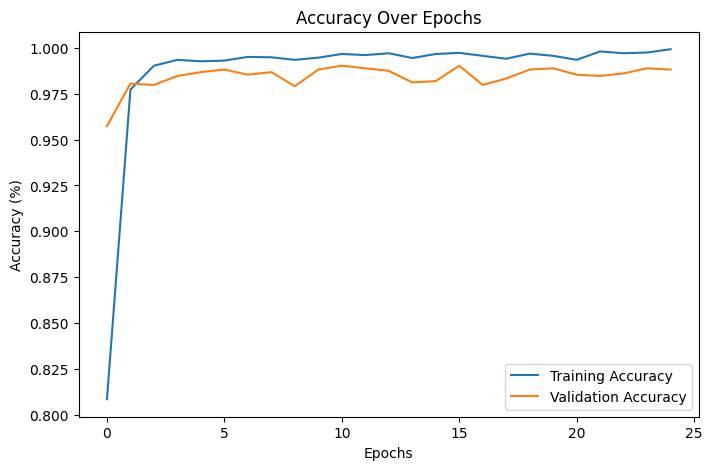

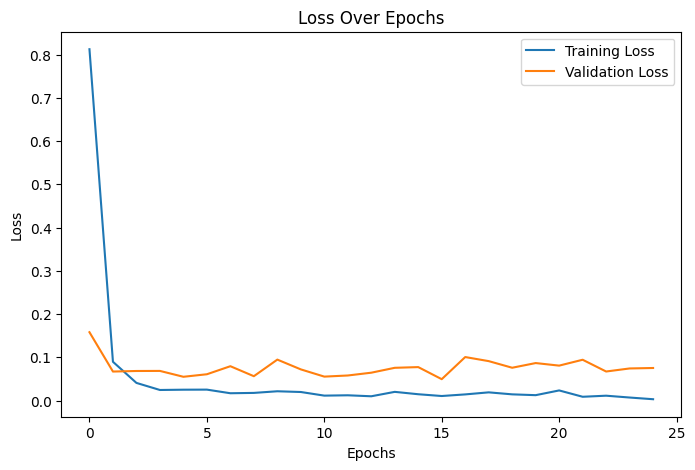

In [ ]:
# Plot training history
plt.figure(figsize=(8, 5))
plt.plot(history.history["accuracy"] , label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"] , label="Training Loss")
plt.plot(history.history["val_loss"] , label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.show()

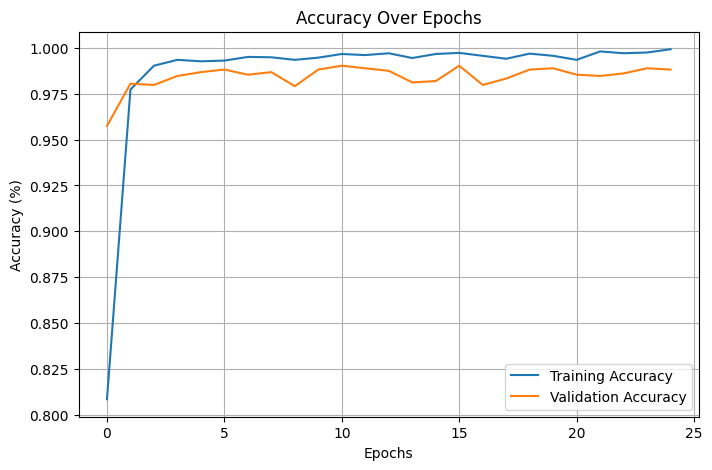

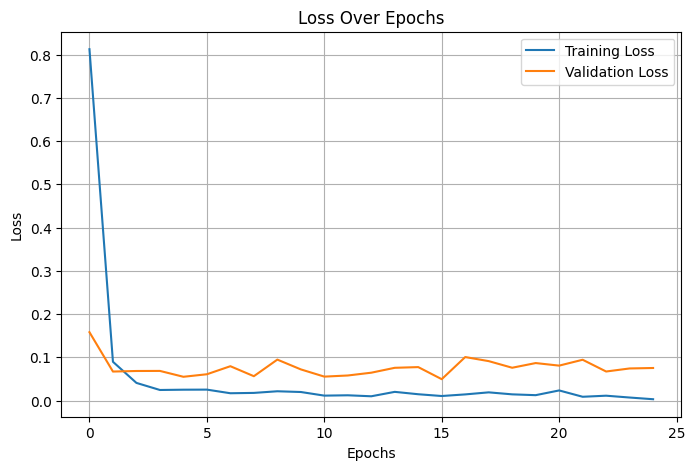

In [ ]:
# Plot training history
plt.figure(figsize=(8, 5))
plt.plot(history.history["accuracy"] , label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"] , label="Training Loss")
plt.plot(history.history["val_loss"] , label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(y_true, y_pred_classes)

23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 307ms/step


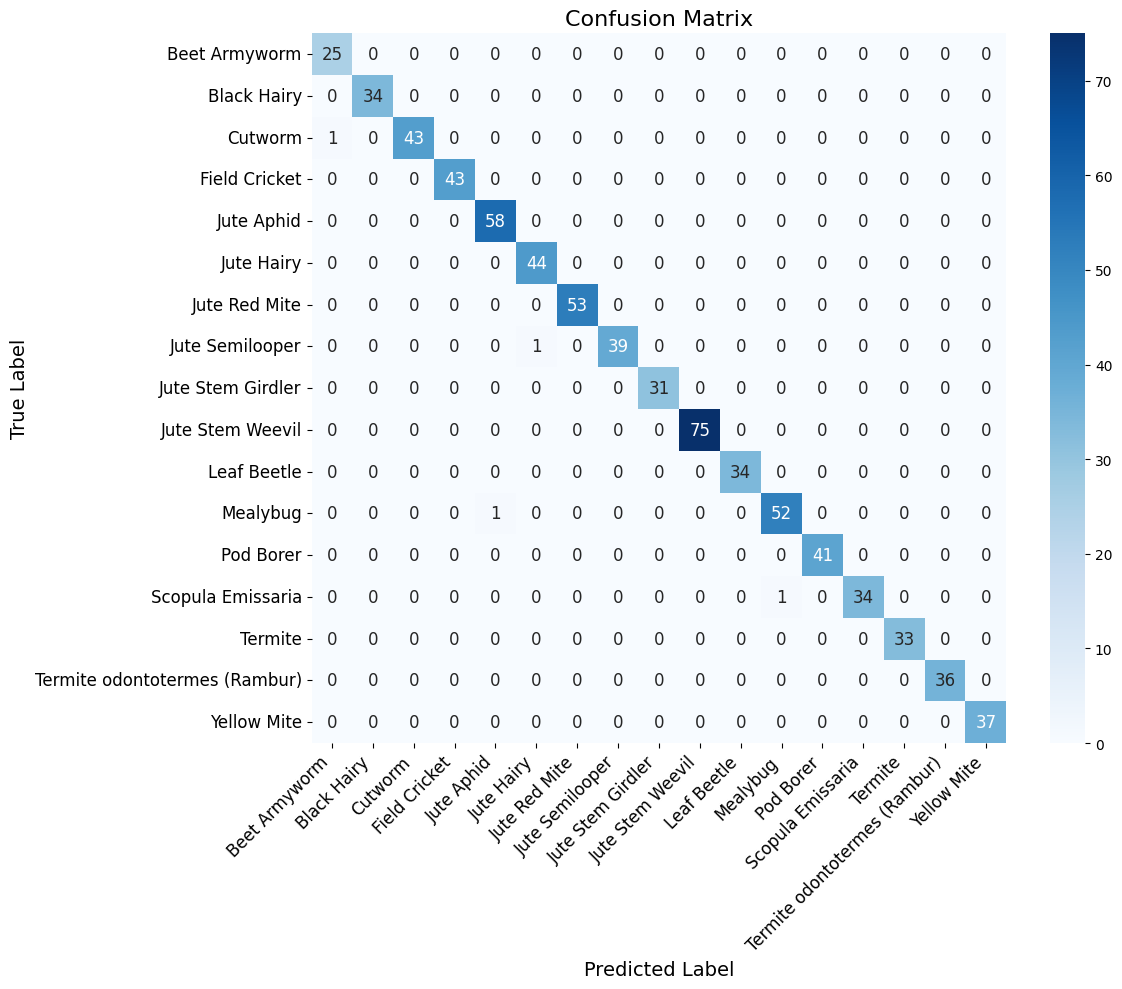

In [ ]:
# Plot confusion matrix using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels,
    cbar=True,
    annot_kws={"size": 12},
)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.xticks(rotation=45, fontsize=12, ha="right")
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# Classification report
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print(report)

                               precision    recall  f1-score   support

                Beet Armyworm       0.96      1.00      0.98        25
                  Black Hairy       1.00      1.00      1.00        34
                      Cutworm       1.00      0.98      0.99        44
                Field Cricket       1.00      1.00      1.00        43
                   Jute Aphid       0.98      1.00      0.99        58
                   Jute Hairy       0.98      1.00      0.99        44
                Jute Red Mite       1.00      1.00      1.00        53
              Jute Semilooper       1.00      0.97      0.99        40
            Jute Stem Girdler       1.00      1.00      1.00        31
             Jute Stem Weevil       1.00      1.00      1.00        75
                  Leaf Beetle       1.00      1.00      1.00        34
                     Mealybug       0.98      0.98      0.98        53
                    Pod Borer       1.00      1.00      1.00        41
     

23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step


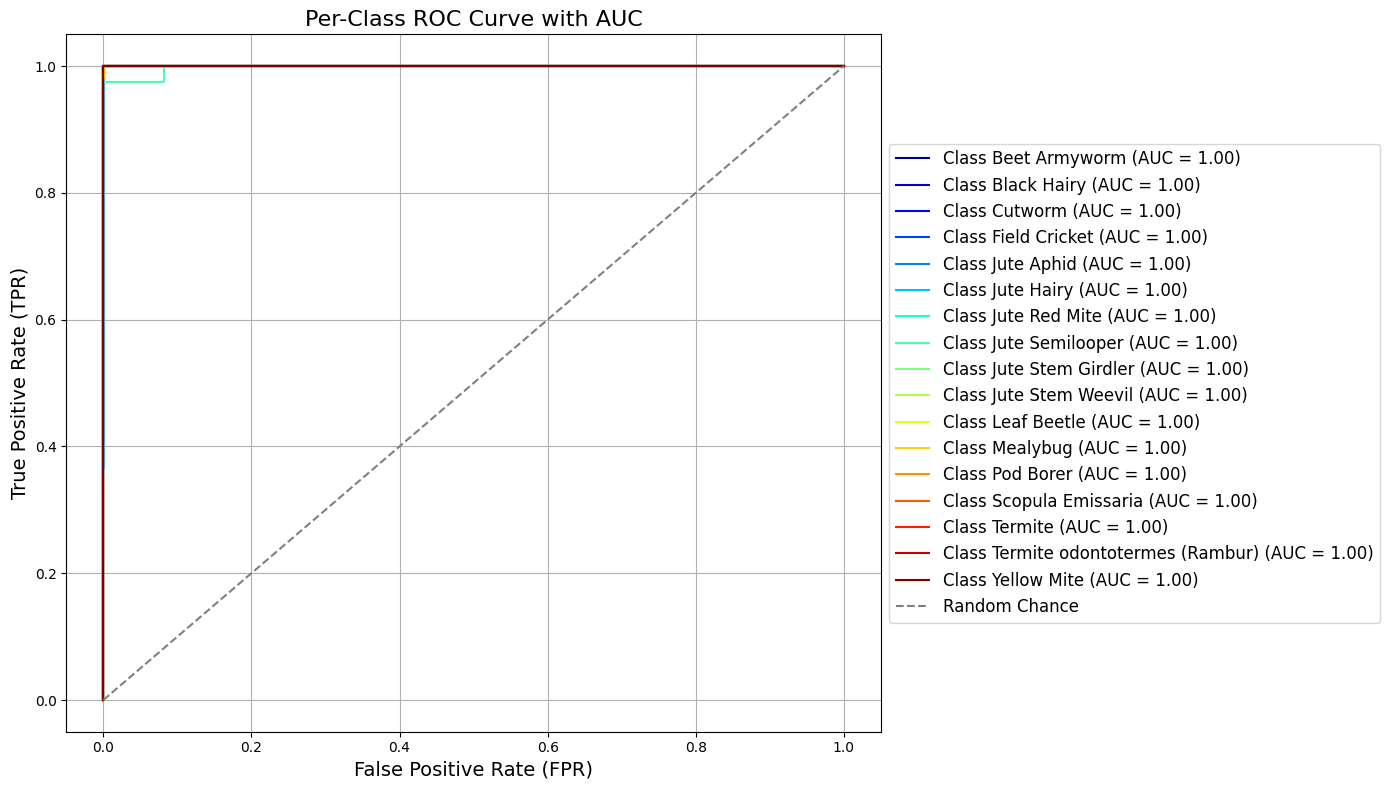

In [ ]:
# ROC Curve
from sklearn.preprocessing import label_binarize # Import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

n_classes = len(test_generator.class_indices)
binarized_labels = label_binarize(test_generator.classes, classes=range(n_classes))

# Predict probabilities
probabilities = model.predict(test_generator, verbose=1)

# Plot ROC curve for each class with different colors
plt.figure(figsize=(14, 8))

# Generate colors using a colormap
colors = plt.cm.jet(np.linspace(0, 1, n_classes))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(binarized_labels[:, i], probabilities[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {list(test_generator.class_indices.keys())[i]} (AUC = {roc_auc:.2f})", color=colors[i])

# Add random chance diagonal line
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Chance")

# Plot settings
plt.xlabel("False Positive Rate (FPR)", fontsize=14)
plt.ylabel("True Positive Rate (TPR)", fontsize=14)
plt.title("Per-Class ROC Curve with AUC", fontsize=16)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step


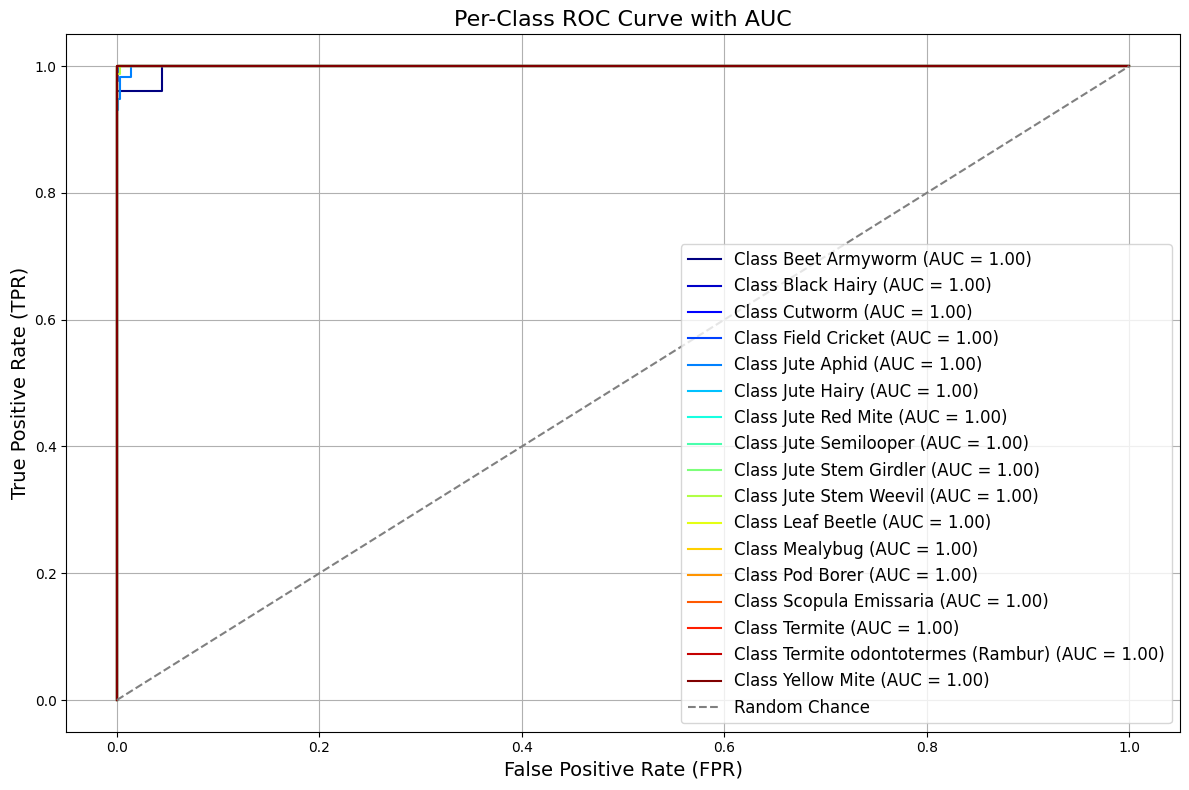

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Number of classes
n_classes = len(test_generator.class_indices)

# Binarize the true labels for multi-class ROC computation
binarized_labels = label_binarize(test_generator.classes, classes=range(n_classes))

# Predict probabilities
probabilities = model.predict(test_generator, verbose=1)

# Plot ROC curve for each class with different colors
plt.figure(figsize=(12, 8))

# Generate colors using a colormap
colors = plt.cm.jet(np.linspace(0, 1, n_classes))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(binarized_labels[:, i], probabilities[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {list(test_generator.class_indices.keys())[i]} (AUC = {roc_auc:.2f})", color=colors[i])

# Add random chance diagonal line
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Chance")

# Plot settings
plt.xlabel("False Positive Rate (FPR)", fontsize=14)
plt.ylabel("True Positive Rate (TPR)", fontsize=14)
plt.title("Per-Class ROC Curve with AUC", fontsize=16)

# Place the legend inside the plot
plt.legend(loc="lower right", fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# Predict a single image
def predict_image(model, img_path, class_labels):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]
    confidence = np.max(prediction) * 100

    return predicted_class, confidence

In [ ]:
# Example usage
img_path = '/content/images (1).jpg'  
predicted_class, confidence = predict_image(model, img_path, class_labels)
print(f"Predicted Class: {predicted_class} with {confidence:.2f}% confidence")